In [1]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import scanpy as sc

In [2]:
adata = sc.read("../../../../data/adata_pancreas_2022_processed_new.h5ad")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


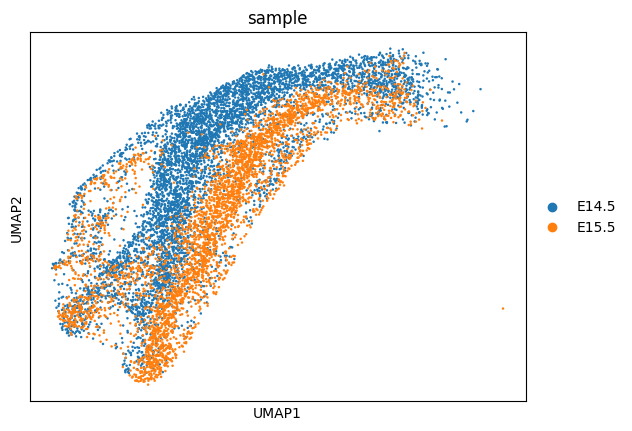

In [3]:
sc.pl.umap(adata, color="sample")

In [4]:
sc.pp.pca(adata, n_comps=10)

In [5]:
source = adata[adata.obs["sample"]=="E14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["sample"]=="E15.5"].obsm["X_pca"].copy()

In [6]:
source.shape

(5539, 10)

In [7]:
kg = KantorovichGapModel(epsilon=0.1, input_dim=[10], iterations=5000)

In [8]:
kg(source, target)

100%|██████████| 5000/5000 [54:30<00:00,  1.53it/s]


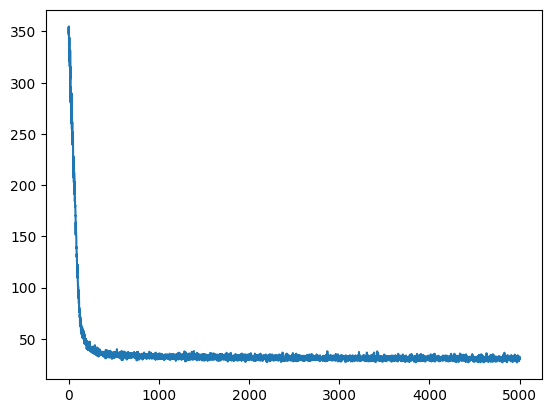

In [20]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["total_loss"])

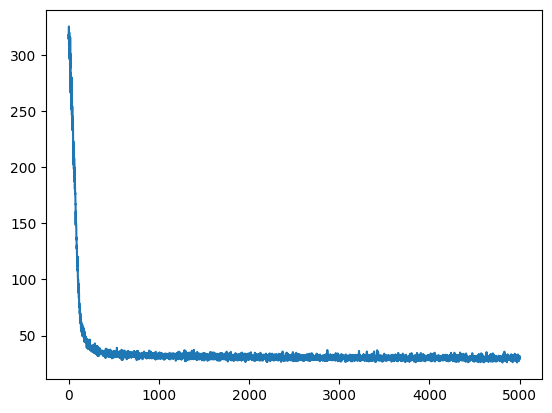

In [21]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

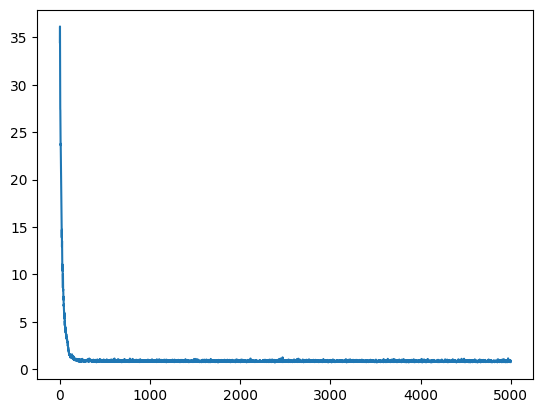

In [11]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["kant_gap"])

In [12]:
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(len(source), 4))
source_with_noise = jnp.concatenate((source, noise), axis=1)
pushed = kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)

In [15]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed, target), axis=0)

In [16]:
del bdata.uns
del bdata.obsp

In [17]:
bdata.obsm

AxisArrays with keys: X_pca, X_pca_wsnn, X_spca_wsnn, X_umap, X_umap_ATAC, X_umap_GEX, X_umap_wsnn, lsi_full, lsi_red, umap, umap_ATAC, umap_GEX, X_pca_result

# Check the fitting term

In [18]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/d

In [19]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


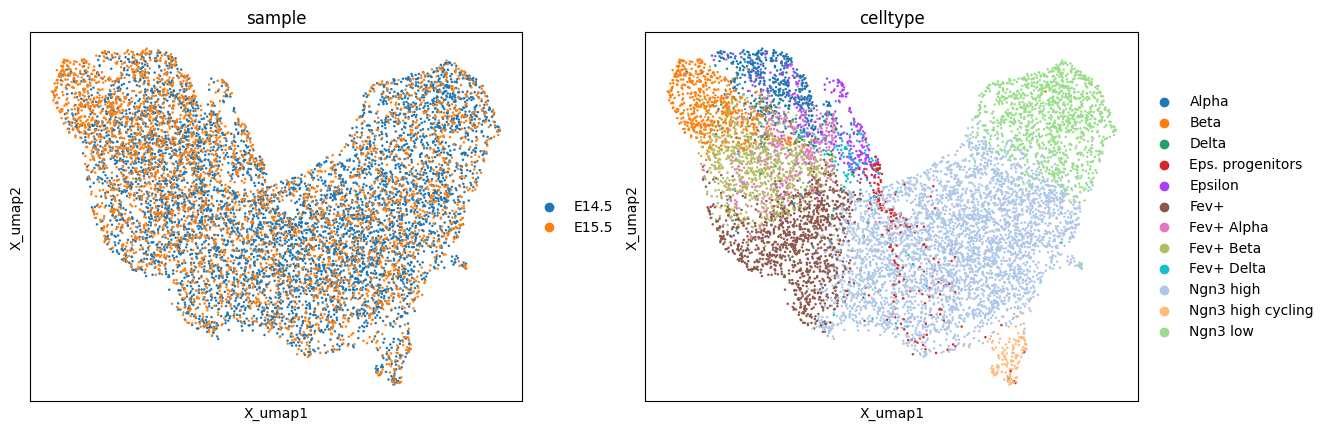

In [49]:
sc.pl.embedding(bdata, basis="X_umap", color=["sample", "celltype"])

# Check the variances

## Check variances on source+target

In [45]:
for j in range(10):
    res = [None] * 15
    for i in range(15):
        noise = jax.random.normal(jax.random.PRNGKey(j*10+i), shape=(len(adata), 4))
        source_with_noise = jnp.concatenate((adata.obsm["X_pca"], noise), axis=1)
        res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)
    samples = jnp.array(res)
    vars = jnp.var(samples, axis=0)
    vars_summed = jnp.sum(vars, axis=1)
    bdata.obs[f"var_{j}"] = np.asarray(vars_summed)

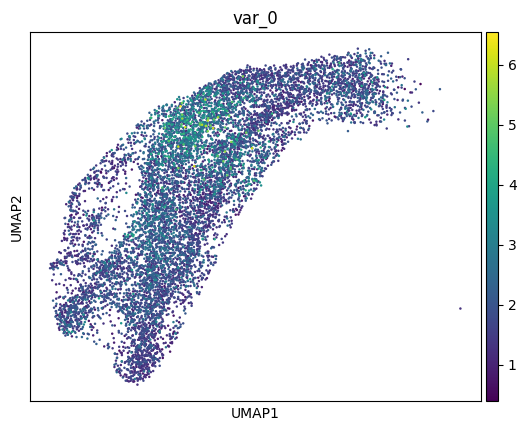

In [46]:
sc.pl.umap(bdata, color="var_0")

In [47]:
ls_vars = []
for j in range(10):
    ls_vars.append(bdata[bdata.obs["sample"]=="E14.5"].obs[["celltype", f"var_{j}"]].groupby("celltype").mean())

In [94]:
df_vars = pd.concat(ls_vars, axis=1)

In [95]:
var_cols = [f"var_{j}" for j in range(10)]
df_vars['mean_of_vars'] = df_vars[var_cols].mean(axis=1)
df_vars['var_of_vars'] = df_vars[var_cols].var(axis=1)

In [97]:
order_celltypes = ["Alpha", "Beta", "Delta", "Epsilon", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+", "Eps. progenitors", "Ngn3 high", "Ngn3 high cycling", "Ngn3 low"]
df_vars = df_vars.reindex(order_celltypes)

/tmp/ipykernel_43085/2473399689.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_vars.index, rotation = 45)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 high cycling'),
 Text(11, 0, 'Ngn3 low')]

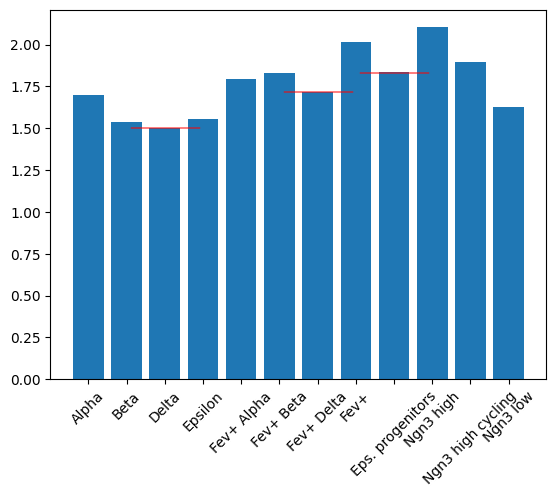

In [98]:
fig = plt.figure(1)
ax = fig.add_subplot(111)

plt.bar(df_vars.index, df_vars["mean_of_vars"], yerr=df_vars["var_of_vars"], error_kw=dict(elinewidth=50, ecolor='r'))
ax.set_xticklabels(df_vars.index, rotation = 45)

## Check variances on source

In [135]:
bdata_early = bdata[bdata.obs["sample"]=="E14.5"]
bdata_late = bdata[bdata.obs["sample"]=="E15.5"]

In [136]:
for j in range(10):
    res = [None] * 15
    for i in range(15):
        noise = jax.random.normal(jax.random.PRNGKey(j*10+i), shape=(len(adata_early), 4))
        source_with_noise = jnp.concatenate((adata_early.obsm["X_pca"], noise), axis=1)
        res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)
    samples = jnp.array(res)
    vars = jnp.var(samples, axis=0)
    vars_summed = jnp.sum(vars, axis=1)
    bdata_early.obs[f"var_{j}"] = np.asarray(vars_summed)

/tmp/ipykernel_43085/1104670147.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_early.obs[f"var_{j}"] = np.asarray(vars_summed)


In [137]:
ls_vars = []
for j in range(10):
    ls_vars.append(bdata_early[bdata_early.obs["sample"]=="E14.5"].obs[["celltype", f"var_{j}"]].groupby("celltype").mean())

In [138]:
df_vars = pd.concat(ls_vars, axis=1)

In [139]:
var_cols = [f"var_{j}" for j in range(10)]
df_vars['mean_of_vars'] = df_vars[var_cols].mean(axis=1)
df_vars['var_of_vars'] = df_vars[var_cols].var(axis=1)

In [140]:
df_vars = df_vars.reindex(order_celltypes)

/tmp/ipykernel_43085/2473399689.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_vars.index, rotation = 45)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 high cycling'),
 Text(11, 0, 'Ngn3 low')]

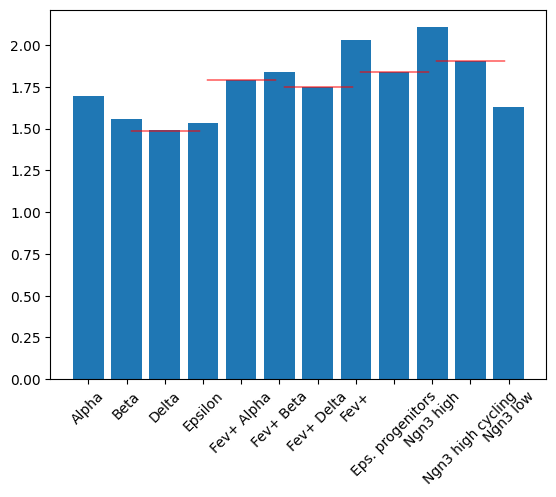

In [141]:
fig = plt.figure(1)
ax = fig.add_subplot(111)

plt.bar(df_vars.index, df_vars["mean_of_vars"], yerr=df_vars["var_of_vars"], error_kw=dict(elinewidth=50, ecolor='r'))
ax.set_xticklabels(df_vars.index, rotation = 45)

## Check variances on target

In [142]:
for j in range(10):
    res = [None] * 15
    for i in range(15):
        noise = jax.random.normal(jax.random.PRNGKey(j*10+i), shape=(len(adata_late), 4))
        source_with_noise = jnp.concatenate((adata_late.obsm["X_pca"], noise), axis=1)
        res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)
    samples = jnp.array(res)
    vars = jnp.var(samples, axis=0)
    vars_summed = jnp.sum(vars, axis=1)
    bdata_late.obs[f"var_{j}"] = np.asarray(vars_summed)

/tmp/ipykernel_43085/2917803366.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_late.obs[f"var_{j}"] = np.asarray(vars_summed)


In [150]:
ls_vars = []
for j in range(10):
    ls_vars.append(bdata_late.obs[["celltype", f"var_{j}"]].groupby("celltype").mean())

In [151]:
df_vars = pd.concat(ls_vars, axis=1)

In [152]:
var_cols = [f"var_{j}" for j in range(10)]
df_vars['mean_of_vars'] = df_vars[var_cols].mean(axis=1)
df_vars['var_of_vars'] = df_vars[var_cols].var(axis=1)

In [153]:
df_vars = df_vars.reindex(order_celltypes)

/tmp/ipykernel_43085/2473399689.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_vars.index, rotation = 45)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 high cycling'),
 Text(11, 0, 'Ngn3 low')]

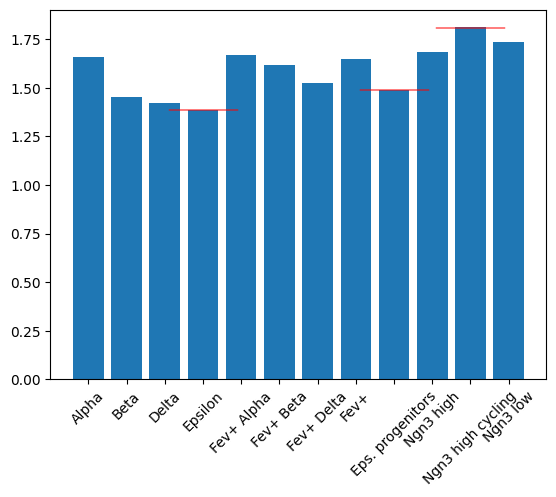

In [155]:
fig = plt.figure(1)
ax = fig.add_subplot(111)

plt.bar(df_vars.index, df_vars["mean_of_vars"], yerr=df_vars["var_of_vars"], error_kw=dict(elinewidth=50, ecolor='r'))
ax.set_xticklabels(df_vars.index, rotation = 45)

# Check accuracy of the model

In [99]:
from typing import Callable, Optional, Tuple, Union, List
import scipy.sparse as sp


def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  # type:ignore[override]
        transport_map: Callable[[jnp.ndarray], jnp.ndarray],
        src_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 30,
        length_scale: Optional[float] = None,
        seed: int = 42,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        if length_scale is None:
            key = jax.random.PRNGKey(seed)
            src_batch = jax.random.choice(key, src_cells.shape[0], shape=((batch_size,)))
            tgt_batch = jax.random.choice(key, tgt_cells.shape[0], shape=((batch_size,)))
            mapped_batch = transport_map(src_cells[src_batch,:])
            length_scale = jnp.std(jnp.concatenate((mapped_batch, tgt_cells[tgt_batch,:])))
        for index in range(0, len(src_cells), batch_size):
            distances, indices = get_knn_fn(transport_map(src_cells[index : index + batch_size]), tgt_cells, k)
            distances = jnp.exp(-((distances / length_scale) ** 2))
            distances /= jnp.expand_dims(jnp.sum(distances, axis=1), axis=1)
            distances_list.append(distances.flatten())
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(src_cells) - index)), min(k, len(tgt_cells)))
            )
        distances = jnp.concatenate(distances_list)
        row_indices = jnp.concatenate(row_indices)
        column_indices = jnp.concatenate(column_indices)
        tm = sp.csr_matrix((distances, (row_indices, column_indices)), shape=[len(src_cells), len(tgt_cells)])
        return tm

In [103]:
source = adata[adata.obs["sample"]=="E14.5"].obsm["X_pca"]
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(len(source), 4))
source_with_noise = jnp.concatenate((source, noise), axis=1)
pushed = kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)

r = lambda x: kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, x)
key = jax.random.PRNGKey(0)
src_batch = jax.random.choice(key, source_with_noise.shape[0], shape=((1024,)))
r2 = r(source_with_noise[src_batch][:,])

In [104]:
tm = project_transport_matrix(lambda x: kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, x), source_with_noise, target)

In [105]:
tm_df = pd.DataFrame(data=tm.A, index=adata[adata.obs["sample"]=="E14.5"].obs.index, columns = adata[adata.obs["sample"]=="E15.5"].obs.index)

In [108]:
adata_early = adata[adata.obs["sample"]=="E14.5"]
adata_late = adata[adata.obs["sample"]=="E15.5"]

df_res = pd.DataFrame(index=adata_early.obs["celltype"].cat.categories)
for ct in adata_late.obs["celltype"].cat.categories:
    cols_cell_type = adata_late[adata_late.obs["celltype"] == ct].obs.index
    for ct2 in adata_early.obs["celltype"].cat.categories:
        index_cell_type = adata_early[adata_early.obs["celltype"] == ct2].obs.index
        df_res.loc[ct2, ct] = tm_df.loc[index_cell_type, cols_cell_type].sum().sum()


In [112]:
cell_transition = df_res.div(df_res.sum(axis=1), axis=0)
cell_transition

,Alpha,Beta,Delta,Eps. progenitors,Epsilon,Fev+,Fev+ Alpha,Fev+ Beta,Fev+ Delta,Ngn3 high,Ngn3 high cycling,Ngn3 low
Alpha,0.670501,0.115404,0.018857,0.000000,0.013657,0.000710,0.106561,0.071974,0.002337,0.000000,0.000000,0.000000
Beta,0.002806,0.959694,0.000503,0.000000,0.000000,0.000000,0.000905,0.035957,0.000136,0.000000,0.000000,0.000000
Delta,0.086849,0.335414,0.150165,0.000000,0.024111,0.004742,0.094616,0.269629,0.034473,0.000000,0.000000,0.000000
Eps. progenitors,0.000008,0.000000,0.000399,0.386348,0.090466,0.017630,0.000245,0.000712,0.086086,0.418107,0.000000,0.000000
Epsilon,0.150883,0.014188,0.046286,0.046032,0.498196,0.006285,0.058017,0.019754,0.157121,0.003238,0.000000,0.000000
Fev+,0.000083,0.000882,0.001402,0.000250,0.000613,0.731789,0.046866,0.180191,0.002903,0.032207,0.002784,0.000031
Fev+ Alpha,0.126279,0.015406,0.017044,0.000004,0.003604,0.036239,0.427179,0.349857,0.020540,0.000097,0.003752,0.000000
Fev+ Beta,0.005178,0.225172,0.003542,0.000000,0.000000,0.045654,0.043854,0.673406,0.000970,0.000054,0.000000,0.002169
Fev+ Delta,0.054551,0.012045,0.078311,0.053213,0.151143,0.110577,0.137132,0.108922,0.238195,0.055911,0.000000,0.000000
Ngn3 high,0.000000,0.000018,0.000018,0.017869,0.000048,0.050975,0.000283,0.000459,0.001344,0.922823,0.000974,0.005190


<Axes: >

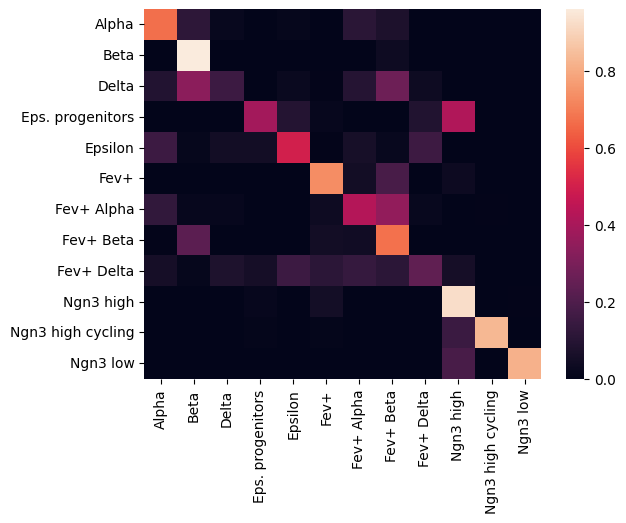

In [132]:
sns.heatmap(cell_transition)

In [ ]:
1